## Trabajo Practico 3

#### Materia: Vision por Computadora 1
#### Alumno: Lucas Rivela

In [1]:
import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.object_detection import non_max_suppression

#### Parte 1

##### Objetivo

Hacer template matching para detectar el logo de Coca Cola en diferentes imagenes, dibujando un bounding box para la deteccion y su nivel de confianza.

175 400


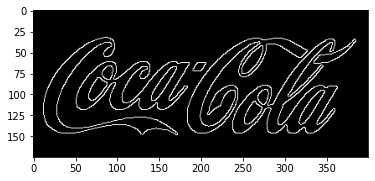

In [2]:
# Cargo el template, aplico Canny para deteccion de bordes e imprimo las dimensiones
template = cv.imread('./template/pattern.png')
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
template = cv.Canny(template, 50, 200, L2gradient=True)
(tH, tW) = template.shape[:2]

print(tH, tW)
plt.imshow(template, cmap='gray')

In [59]:
# Veo las dimensiones de las imagenes donde tengo que encontrar el patron
images_path = [
    './images/coca_logo_1.png', './images/coca_logo_2.png',
    './images/coca_multi.png', './images/coca_retro_1.png', 
    './images/coca_retro_2.png', './images/COCA-COLA-LOGO.jpg', 
    './images/logo_1.png'
]

for path in images_path:
    imag_ = cv.imread(path)
    (h, w) = imag_.shape[:2]
    print(h, w)

500 207
363 233
598 799
493 715
429 715
1389 1389
450 687


Confianza:  99.99999403953552
Escala:  2.3134831460674157


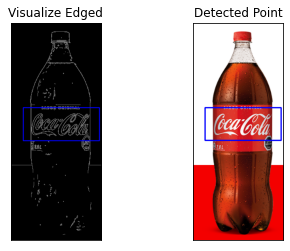

Confianza:  100.0
Escala:  1.7365168539325844


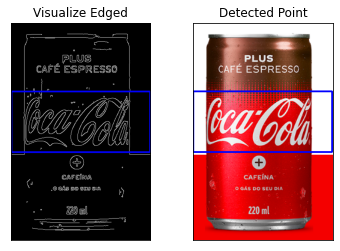

Confianza:  100.0
Escala:  4.0


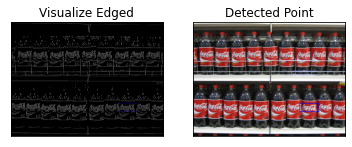

Confianza:  100.0
Escala:  0.7601123595505619


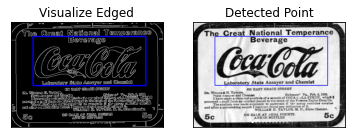

Confianza:  100.0
Escala:  2.801685393258427


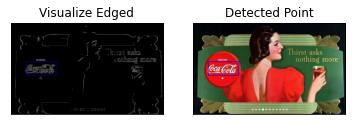

Confianza:  100.0
Escala:  0.3162921348314607


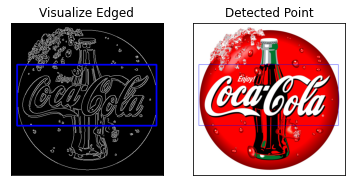

Confianza:  100.0
Escala:  1.3370786516853934


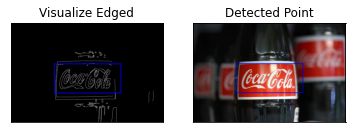

In [79]:
# Para cada imagen
for path in images_path:
    # Cargo imagen
    imag_ = cv.imread(path)

    # Aplico conversiones de color
    image = cv.cvtColor(imag_, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(imag_, cv.COLOR_BGR2GRAY)
    
    found = None  # Variable que vamos a usar para guardar el mejor match
    best_scale = None  # Variable que vamos a usar para guardar la mejor escala
    best_result = None  # Variable que vamos a usar para guardar para guardar la matriz de matchs normalizada

    # Busco escalas, comenzado de mas chica a mas grande.
    # Este factor de escala al principio achica y luego agranda
    for scale in np.linspace(0.05, 4.0, 90)[::]:
        # Resize
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        
        # Si la imagen quedo mas chica que el template paso a la siguiente
        if resized.shape[0] < tH or resized.shape[1] < tW:
            continue

        # Calculo el ratio
        r = gray.shape[1] / float(resized.shape[1])
        
        # Aplico Canny a la imagen
        edged = cv.Canny(resized, 100, 200, L2gradient=True)

        # Busco hacer el match
        result = cv.matchTemplate(edged, template, cv.TM_CCOEFF)

        #Encontramos los valores maximos
        (_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
        
        # Si es la primera o si es un mejor match
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
            best_scale = scale
            ### Normalizo resultado ###
            # matchTemplate devuelve una imagen en escala de grises, donde cada pixel muestra como la vecindad de ese pixel matchea con el template.
            # minMaxLoc lo que hace es encontrar el maximo para decirme donde encontró el mejor match para el template.
            # Como estoy usando un algoritmo que no esta normalizado, voy a usar el normalize minmax de open cv para poner los valores entre 0 y 1
            # y que me sirvan como metrica.
            normalized = cv.normalize(result, result, 0, 1, cv.NORM_MINMAX)
            best_result = cv.minMaxLoc(normalized)
            clone = np.dstack([edged, edged, edged])
            # Dibujo el recuadro sobre la imagen de Canny
            cv.rectangle(clone, (maxLoc[0], maxLoc[1]), (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 4)

    # Unpack de valores
    (_, maxLoc, r) = found

    # Marco el lugar donde se encontró
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    print("Confianza: ", best_result[1] * 100)
    print("Escala: ", best_scale)

    plt.subplot(121),plt.imshow(clone)
    plt.title('Visualize Edged'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(image)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.show()

#### Conclusiones Parte 1

Al tener distintos tamaños de imagenes (incluso algunas donde las dimensiones eran menores que las del template) se implementó una búsqueda del mejor resize para hacer el match. 

Por otro lado, para no estar influenciado por el background del template y de las imágenes (aún pasandolo a escala de grises) se utilizó el algoritmo de Canny para detección de bordes en el template y en las imágenes. De esta manera queda el fondo en negro y los bordes en color más claro.

Posterior a esto, se buscó la ubicación del máximo. Este máximo se fue comparando a lo largo de las distintas escalas y buscando el mejor. 

Una vez terminada la búsqueda se dibujó el bounding box.

Cabe destacar que el algoritmo para hacer match no estaba normalizado, por lo que para buscar una métrica de nivel de confianza se utilizó la función normalize de opencv (ver comentarios en código).



#### Parte 2

#### Objetivo

Desarrollar un algoritmo para realizar multiples detecciones del logo de Coca Cola en la imagen coca_multi.png

Confianza:  1.0
Escala:  4.0


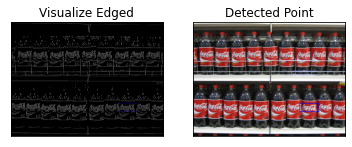

In [97]:
# Cargo imagen
imag_ = cv.imread('./images/coca_multi.png')
# Aplico conversiones de color
image = cv.cvtColor(imag_, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(imag_, cv.COLOR_BGR2GRAY)

found = None  # Variable que vamos a usar para guardar el mejor match
best_scale = None  # Variable que vamos a usar para guardar la mejor escala
best_result = None  # Variable que vamos a usar para guardar para guardar la matriz de matchs normalizada

# Busco escalas, comenzado de mas chica a mas grande.
# Este factor de escala al principio achica y luego agranda
for scale in np.linspace(0.05, 4.0, 90)[::]:
    # Resize
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    
    # Si la imagen quedo mas chica que el template paso a la siguiente
    if resized.shape[0] < tH or resized.shape[1] < tW:
        continue

    # Calculo el ratio
    r = gray.shape[1] / float(resized.shape[1])
    
    # Aplico Canny a la imagen
    edged = cv.Canny(resized, 100, 200, L2gradient=True)
    
    # Busco hacer el match
    result = cv.matchTemplate(edged, template, cv.TM_CCOEFF)
    
    #Encontramos los valores maximos
    (_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
    
    # Si es la primera o si es un mejor match
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)
        best_scale = scale
        ### Normalizo resultado ###
        # matchTemplate devuelve una imagen en escala de grises, donde cada pixel muestra como la vecindad de ese pixel matchea con el template.
        # minMaxLoc lo que hace es encontrar el maximo para decirme donde encontró el mejor match para el template.
        # Como estoy usando un algoritmo que no esta normalizado, voy a usar el normalize minmax de open cv para poner los valores entre 0 y 1
        # y que me sirvan como metrica.
        normalized = cv.normalize(result, result, 0, 1, cv.NORM_MINMAX)
        best_result = cv.minMaxLoc(normalized)
        clone = np.dstack([edged, edged, edged])
        # Dibujo el recuadro sobre la imagen de Canny
        cv.rectangle(clone, (maxLoc[0], maxLoc[1]), (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 4)

# Unpack de valores
(_, maxLoc, r) = found

# Marco el lugar donde se encontró
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

print("Confianza: ", best_result[1])
print("Escala: ", best_scale)

plt.subplot(121),plt.imshow(clone)
plt.title('Visualize Edged'), plt.xticks([]), plt.yticks([])

# Imagen original con recuadros
plt.subplot(122),plt.imshow(image)
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()

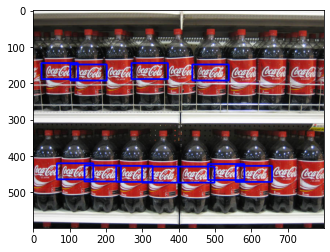

In [105]:
# Cargo de nuevo la imagen para eliminar el recuadro
image = cv.cvtColor(imag_, cv.COLOR_BGR2RGB)

# Limite para elegir los recuadros con mejor match
threshold = 0.8

# Lista de recuadros
rects = []

# Filtro los pixeles con match superior al threshold
(yCoords, xCoords) = np.where(normalized >= threshold)
for (x, y) in zip(xCoords, yCoords):
	# Agrego los rectangulos ajustados a la escala
	rects.append(( int(x*r), int(y*r), int((x + tW)*r), int((y + tH)*r)))

# Aplico supresion de no maximos
pick = non_max_suppression(np.array(rects))

for (startX, startY, endX, endY) in pick:
	# Marco los bounding boxes
	cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 3)

plt.imshow(image)

#### Conclusiones Parte 2

A partir del algoritmo de la parte 1 que encontraba la mejor escala, se procedió a filtrar las mejores coincidencias superiores al threshold en lugar de seleccionar la máxima. Luego se reescaló para dibujar los bounding boxes.

#### Parte 3

#### Objetivo

Desarrollar un algoritmo que haga múltiples detecciones del logo de Coca Cola para cualquier imagen.

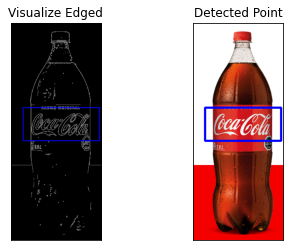

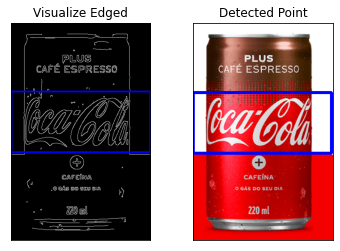

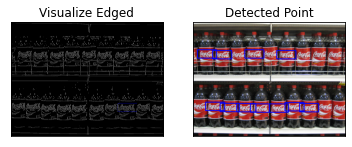

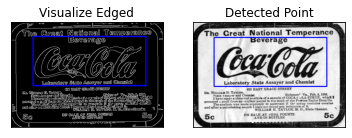

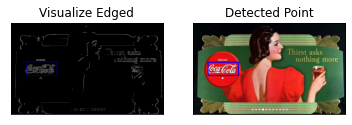

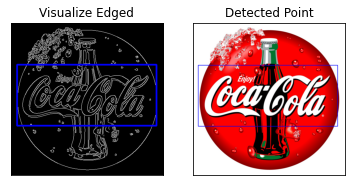

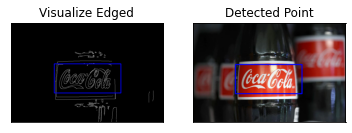

In [110]:
# Para cada imagen
for path in images_path:
    # Cargo imagen
    imag_ = cv.imread(path)
    # Aplico conversiones de color
    image = cv.cvtColor(imag_, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(imag_, cv.COLOR_BGR2GRAY)
    
    found = None  # Variable que vamos a usar para guardar el mejor match
    best_scale = None  # Variable que vamos a usar para guardar la mejor escala
    best_result = None  # Variable que vamos a usar para guardar para guardar la matriz de matchs normalizada
    
    # Busco escalas, comenzado de mas chica a mas grande.
    # Este factor de escala al principio achica y luego agranda
    for scale in np.linspace(0.05, 4.0, 90)[::]:
        # Resize
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        
        # Si la imagen quedo mas chica que el template paso a la siguiente
        if resized.shape[0] < tH or resized.shape[1] < tW:
            continue
        
        # Calculo el ratio
        r = gray.shape[1] / float(resized.shape[1])
        
        # Aplico Canny a la imagen
        edged = cv.Canny(resized, 100, 200, L2gradient=True)
        
        # Busco hacer el match
        result = cv.matchTemplate(edged, template, cv.TM_CCOEFF)
        
        #Encontramos los valores maximos
        (_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
        
        # Si es la primera o si es un mejor match
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
            best_scale = scale
            ### Normalizo resultado ###
            # matchTemplate devuelve una imagen en escala de grises, donde cada pixel muestra como la vecindad de ese pixel matchea con el template.
            # minMaxLoc lo que hace es encontrar el maximo para decirme donde encontró el mejor match para el template.
            # Como estoy usando un algoritmo que no esta normalizado, voy a usar el normalize minmax de open cv para poner los valores entre 0 y 1
            # y que me sirvan como metrica.
            normalized = cv.normalize(result, result, 0, 1, cv.NORM_MINMAX)
            best_result = cv.minMaxLoc(normalized)
            clone = np.dstack([edged, edged, edged])
            # Dibujo el recuadro sobre la imagen de Canny
            cv.rectangle(clone, (maxLoc[0], maxLoc[1]), (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 4)
    
    # Unpack de valores
    (_, maxLoc, r) = found

    # Limite para elegir los recuadros con mejor match
    threshold = 0.8

    # Lista de recuadros
    rects = []

    # Filtro los pixeles con match superior al threshold
    (yCoords, xCoords) = np.where(normalized >= threshold)
    for (x, y) in zip(xCoords, yCoords):
        # Agrego los rectangulos ajustados a la escala
        rects.append(( int(x*r), int(y*r), int((x + tW)*r), int((y + tH)*r)))
    

    # Aplico supresion de no maximos
    pick = non_max_suppression(np.array(rects))

    for (startX, startY, endX, endY) in pick:
    	# Marco los bounding boxes
        cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 3)
        cv.rectangle(edged, (startX, startY), (endX, endY), (0, 0, 255), 3)

    plt.subplot(121),plt.imshow(clone)
    plt.title('Visualize Edged'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(image)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.show()

#### Conclusiones Parte 3

Una vez que se tuvieron los algoritmos de la Parte 1 y 2, solo fue cuestión de juntarlos y aplicar el threshold correcto.